# ISLR- Python: Ch5 -- Lab: Resampling Methods

In [1]:
# perform standard imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In this lab, we explore the resampling techniques covered in this chapter. Some of the commands in this lab may take a while to run on your computer.

## The Validation Set Approach

We explore the use of the validation set approach in order to estimate the test error rates that result from fitting various linear models on the `Auto` data set.

Before we begin, we use the np.seed() function in order to set a seed for Python's random number generator, so that the the results are reproducible. It is generally a good idea to set a random seed when performing an analysis such as cross-validation that contains an element of randomness, so that the results obtained can be reproduced precisely at a later time.

We begin by splitting the set of observations into two halves, by selecting a random subset of 196 observations out of the original 392 observations. We refer to these observations as the training set.

In [2]:
# load auto dataset, note before we have found that horsepower column contains ? values we convert to nans
auto = pd.read_csv('Data/Auto.csv', na_values='?')
auto = auto.dropna()

In [3]:
# Set the random seed so we always get the same results
np.random.seed(0)

# Split the data in half
auto_train = auto.sample(frac=0.5)
auto_test = auto.drop(auto_train.index)

We then fit a linear regression using only the observations corresponding to the training set.

In [4]:
import statsmodels.formula.api as smf

In [5]:
lm_fit = smf.ols('mpg ~ horsepower', auto_train).fit()

We now use the predict() function to estimate the response for all 392 observations, and we use the mean() function to calculate the MSE of the 196 observations in the validation set.

In [6]:
np.mean((auto_test.mpg - lm_fit.predict(auto_test))**2)

24.397230304032295

Therefore, the estimated test MSE for the linear regression fit is 24.39. We can also estimate the test error for the quadratic and cubic regressions.

In [7]:
lm_fit2 = smf.ols('mpg ~ horsepower + np.power(horsepower,2)', auto_train).fit()
np.mean((auto_test.mpg - lm_fit2.predict(auto_test))**2)

19.243963562139005

In [8]:
lm_fit3 = smf.ols('mpg ~ horsepower + np.power(horsepower,2) + np.power(horsepower,3)', auto_train).fit()
np.mean((auto_test.mpg - lm_fit3.predict(auto_test))**2)

19.20046416864905

These error rates are 19.24 and 19.20, respectively. If we choose a different training set instead, then we will obtain somewhat different errors on the validation set.

In [9]:
np.random.seed(1)

# Split the data in half
auto_train = auto.sample(frac=0.5)
auto_test = auto.drop(auto_train.index)

In [10]:
lm_fit = smf.ols('mpg ~ horsepower', auto_train).fit()
np.mean((auto_test.mpg - lm_fit.predict(auto_test))**2)

23.36190289258723

In [11]:
lm_fit2 = smf.ols('mpg ~ horsepower + np.power(horsepower,2)', auto_train).fit()
np.mean((auto_test.mpg - lm_fit2.predict(auto_test))**2)

20.252690858350196

In [12]:
lm_fit3 = smf.ols('mpg ~ horsepower + np.power(horsepower,2) + np.power(horsepower,3)', auto_train).fit()
np.mean((auto_test.mpg - lm_fit3.predict(auto_test))**2)

20.325609365878574

Using this split of the observations into a training set and a validation set, we find that the validation set error rates for the models with linear, quadratic, and cubic terms are 23.36, 20.25, and 20.32, respectively.

These results are consistent with our previous findings: a model that predicts mpg using a quadratic function of horsepower performs better than a model that involves only a linear function of horsepower, and there is little evidence in favor of a model that uses a cubic function of horsepower.

## Leave-One-Out Cross-Validation

In the above validation approach, it was easy to use the statsmodels api to construct models and then calculate the MSE using the validation set approach. However, statsmodels does not have direct support for cross-validations i.e. LOOCV or K-fold. We will use the sklearn module here.

In [13]:
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

<ipython-input-14-6b15bbb78700>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:,np.newaxis]


0 1
Coefficients: Intercept, Beta(s) 39.93586102117047 [-0.15784473]
1 2
Coefficients: Intercept, Beta(s) 56.90009970211294 [-0.46618963  0.00123054]
2 3
Coefficients: Intercept, Beta(s) 60.684784906660624 [-5.68850128e-01  2.07901126e-03 -2.14662591e-06]
3 4
Coefficients: Intercept, Beta(s) 47.567677232175285 [-7.66721351e-02 -4.34464058e-03  3.24511548e-05 -6.53036297e-08]
4 5
Coefficients: Intercept, Beta(s) -32.23055992063124 [ 3.70010896e+00 -7.14240770e-02  5.93108566e-04 -2.28107626e-06
  3.32955306e-09]

The estimated test MSEs =  [24.23151352 19.24821312 19.33498406 19.42443031 19.03321351]


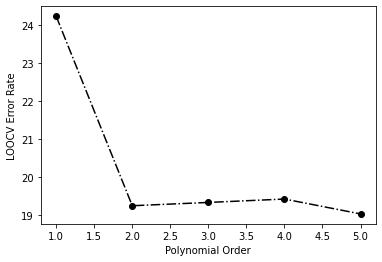

In [14]:
# Create design matrix and Responses
X = auto.horsepower
X = X[:,np.newaxis]
y = auto.mpg

# Perform LOOCV for 5 Polynomial Models #
#########################################
# We will create models of order 1 through 5, fit and perform LOOCV

# create arrays for polnomial order and error estimates
orders = np.arange(1,6)
mse_est = np.array([])

for index, order in enumerate(orders):
    print(index,order)
    # create a polynomial of degree order, don't add bias, LinearRegression does so below
    poly = PolynomialFeatures(degree=order, interaction_only=False, include_bias=False)
        
    # create a linear model and Fit
    regress = LinearRegression()
    regress.fit(poly.fit_transform(X), y)
        
    # print the coeffecients
    print('Coefficients: Intercept, Beta(s)', regress.intercept_, regress.coef_)
        
    # Evaluate the model using Leave-one-out cross-validation (cv = len(X)) to get the MSE estimate
    mse_est = np.append(mse_est, -np.mean(model_selection.cross_val_score(regress, poly.fit_transform(X), y, 
                                                               cv=len(X), scoring='neg_mean_squared_error')))

# print the estimated test MSEs for each model
print('\nThe estimated test MSEs = ', mse_est)

# plt the estimate 
fig , ax = plt.subplots(figsize=(6,4))
ax.plot(orders,mse_est,linestyle = '-.', marker='o',color='k');
ax.set_xlabel('Polynomial Order');
ax.set_ylabel('LOOCV Error Rate');

We see a sharp drop in the estimated test MSE between the linear and quadratic fits, but then no clear improvement from using higher-order polynomials.

## 5.3.3 k-Fold Cross Validation

The same functions can also be used to implement k-fold CV. Below we use k = 10, a common choice for k, on the Auto data set. We simply copy the lines of code above using 10 folds instead of n folds in the cross-validation to be explicit.

Coefficients: Intercept, Beta(s) 39.93586102117047 [-0.15784473]
Coefficients: Intercept, Beta(s) 56.90009970211294 [-0.46618963  0.00123054]
Coefficients: Intercept, Beta(s) 60.684784906660624 [-5.68850128e-01  2.07901126e-03 -2.14662591e-06]
Coefficients: Intercept, Beta(s) 47.567677232175285 [-7.66721351e-02 -4.34464058e-03  3.24511548e-05 -6.53036297e-08]
Coefficients: Intercept, Beta(s) -32.23055992063124 [ 3.70010896e+00 -7.14240770e-02  5.93108566e-04 -2.28107626e-06
  3.32955306e-09]
Coefficients: Intercept, Beta(s) -162.14091544394992 [ 1.12380262e+01 -2.43635760e-01  2.58013793e-03 -1.45299432e-05
  4.17283152e-08 -4.80321338e-11]
Coefficients: Intercept, Beta(s) 14.44982922976428 [ 1.26582488e-03  4.70163674e-02 -1.39352052e-03  1.65926766e-05
 -9.84784095e-08  2.89727100e-10 -3.36952688e-13]
Coefficients: Intercept, Beta(s) 37.417090300836065 [ 5.07488799e-08  2.78288796e-06  9.50779732e-05 -4.46259657e-06
  6.36062580e-08 -4.12395441e-10  1.27127759e-12 -1.51535931e-15]
Co

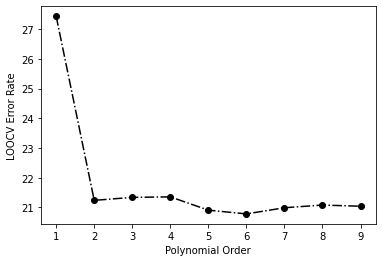

In [15]:
# create arrays for polnomial order and error estimates
orders = np.arange(1,10)
mse_est = np.array([])

for index, order in enumerate(orders):
    # create a polynomial of degree order, don't add bias, LinearRegression does so below
    poly = PolynomialFeatures(degree=order, interaction_only=False, include_bias=False)
        
    # create a linear model and Fit
    regress = LinearRegression()
    regress.fit(poly.fit_transform(X), y)
        
    # print the coeffecients
    print('Coefficients: Intercept, Beta(s)', regress.intercept_, regress.coef_)
        
    # Evaluate the model using Leave-one-out cross-validation (cv = len(X)) to get the MSE estimate
    mse_est = np.append(mse_est, -np.mean(model_selection.cross_val_score(regress, poly.fit_transform(X), y, 
                                                               cv=10, scoring='neg_mean_squared_error')))

# print the estimated test MSEs for each model
print('\nThe estimated test MSEs = ', mse_est)

# plt the estimate 
fig , ax = plt.subplots(figsize=(6,4))
ax.plot(orders,mse_est,linestyle = '-.', marker='o',color='k');
ax.set_xlabel('Polynomial Order');
ax.set_ylabel('LOOCV Error Rate');

Notice that the computation time is much shorter than that of LOOCV. (In principle, the computation time for LOOCV for a least squares linear model should be faster than for k-fold CV, due to the availability of the formula (5.2) for LOOCV; however, unfortunately the cv function does not make use of this formula.) We still see little evidence that using cubic or higher-order polynomial terms leads to lower test error than simply using a quadratic fit.

## The Bootstrap

We illustrate the use of the bootstrap in the simple example of Section 5.2, as well as on an example involving estimating the accuracy of the linear regression model on the Auto data set.

### Estimating the Accuracy of a Statistic of Interest

One of the great advantages of the bootstrap approach is that it can be applied in almost all situations. No complicated mathematical calculations are required. Performing a bootstrap analysis in Python entails only two steps. First, we must create a function that computes the statistic of interest. Second, we define the boot() function to perform the bootstrap by repeatedly sampling observations from the data set with replacement.

The Portfolio data set is described in Section 5.2. To illustrate the use of the bootstrap on this data, we must first create a function, alpha(), which takes as input the (X, Y) data as well as a vector indicating which observations should be used to estimate α. The function then outputs the estimate for α based on the selected observations.

In [16]:
# load the portfolio data set
portfolio = pd.read_csv('Data/Portfolio.csv', index_col=0)
print('\n',len(portfolio),'Rows')
portfolio.head()


 100 Rows


,X,Y
1,-0.895251,-0.234924
2,-1.562454,-0.885176
3,-0.417090,0.271888
4,1.044356,-0.734198
5,-0.315568,0.841983


In [17]:
# We first need a function aplha to return the alpha statistic eqn. 5.7 in the text
def alpha(df, indices):
    """ 
    Returns the alpha statistic for  the rows defined by indices from dataframe df.
    """
    # Get X,Y
    X = df.X[indices].values
    Y = df.Y[indices].values
    
    # np.cov returns full cov matrix we need [0][1] cov(x,y)
    return (np.var(Y) - np.cov(X,Y)[0][1])/(np.var(X) + np.var(Y) - 2*np.cov(X,Y)[0][1])

This function returns, or outputs, an estimate for α based on applying (5.7) to the observations indexed by the argument index. For instance, the following command tells Python to estimate α using all 100 observations.

In [18]:
alpha(portfolio, portfolio.index)

0.5766511516104116

The next command uses the sample() function to randomly select 100 observations from the range 1 to 100, with replacement. This is equivalent to constructing a new bootstrap data set and recomputing $\hat\alpha$ based on the new data set.

In [19]:
np.random.seed(0)
indices = np.random.choice(portfolio.index, 100, replace=True)
alpha(portfolio, indices)

0.560336658007497

We can implement a bootstrap analysis by performing this command many times, recording all of the corresponding estimates for α, and computing the resulting standard deviation.

In [20]:
import scipy

def boot(data, statsfunc, num_bootstrap_samples=1000, sample_size=100):
    """
    Returns the SE of the statistic returned by statsfunc when applied to data using num_bootstrap samples.
    """
    stat_samples = []
    for sample in range(num_bootstrap_samples):
        # apply our stats_func to generate a sample statistic
        indices = np.random.choice(data.index, sample_size, replace=True)
        stat_samples.append(statsfunc(data, indices))
    # compute the std of the statistic samples
    se_estimate = scipy.std(stat_samples, axis=0)
    
    print('\nBootstrapped Std. Error(s) =', se_estimate)

In [21]:
np.random.seed(0)
boot(portfolio, alpha, 1000, 100)


Bootstrapped Std. Error(s) = 0.08980409161302538


<ipython-input-20-98ce5227915c>:13: DeprecationWarning: scipy.std is deprecated and will be removed in SciPy 2.0.0, use numpy.std instead
  se_estimate = scipy.std(stat_samples, axis=0)


The final output shows that using the original data, $\hat\alpha = 0.5758$, and that the bootstrap estimate for $SE(\hat\alpha)$ is 0.0898.

### Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used to assess the variability of the coefficient estimates and predictions from a statistical learning method. Here we use the bootstrap approach in order to assess the variability of the estimates for $\beta_0$ and $\beta_1$, the intercept and slope terms for the linear regression model that uses horsepower to predict mpg in the Auto data set. We will compare the estimates obtained using the bootstrap to those obtained using the formulas for $SE(\hat\beta_0)$ and $SE(\hat\beta_1)$ described in Section 3.1.2.

We first create a simple function, boot_fn(), which takes in the Auto data set as well as a set of indices for the observations, and returns the intercept and slope estimates for the linear regression model. We then apply this
function to the full set of 392 observations in order to compute the estimates of $\beta_0$ and $\beta_1$ on the entire data set using the usual linear regression coefficient estimate formulas from Chapter 3.

In [22]:
import statsmodels.api as sm

In [23]:
def boot_fn(df, indices):
    X = df.horsepower[indices].values
    X = sm.add_constant(X)
    y = df.mpg[indices].values
    lm_fit = sm.OLS(y, X).fit()
    return lm_fit.params

In [24]:
boot_fn(auto, auto.index)

array([39.93586102, -0.15784473])

The boot_fn() function can also be used in order to create bootstrap estimates for the intercept and slope terms by randomly sampling from among the observations with replacement. Here we give two examples.

In [25]:
np.random.seed(0)
indices = np.random.choice(auto.index, len(auto), replace=True)
boot_fn(auto, indices)

array([40.48043887, -0.16156162])

In [26]:
np.random.seed(1)
indices = np.random.choice(auto.index, len(auto), replace=True)
boot_fn(auto, indices)

array([39.65847877, -0.15589835])

Next, we use the boot() function to compute the standard errors of 1,000 bootstrap estimates for the intercept and slope terms.

In [27]:
boot(auto, boot_fn, num_bootstrap_samples=1000, sample_size=len(auto))


Bootstrapped Std. Error(s) = [0.82521528 0.00713533]


<ipython-input-20-98ce5227915c>:13: DeprecationWarning: scipy.std is deprecated and will be removed in SciPy 2.0.0, use numpy.std instead
  se_estimate = scipy.std(stat_samples, axis=0)


This indicates that the bootstrap estimate for $SE(\hat\beta_0)$ is 0.88, and that the bootstrap estimate for $SE(\hat\beta_1)$ is 0.0076. As discussed in Section 3.1.2, standard formulas can be used to compute the standard errors for the
regression coefficients in a linear model. These can be obtained using the summary() function.

In [28]:
smf.ols('mpg~horsepower', auto).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           7.03e-81
Time:                        01:13:35   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The standard error estimates for $\hat\beta_0$ and $\hat\beta_1$ obtained using the formulas from Section 3.1.2 are 0.717 for the intercept and 0.0064 for the slope. Interestingly, these are somewhat different from the estimates obtained using the bootstrap. Does this indicate a problem with the bootstrap? In fact, it suggests the opposite. Recall that the standard formulas given in Equation 3.8 on page 66 rely on certain assumptions. For example, they depend on the unknown parameter $\sigma^2$, the noise variance. We then estimate $\sigma^2$ using the RSS. Now although the formula for the standard errors do not rely on the linear model being correct, the estimate for $\sigma^2$ does. We see in Figure 3.8 on page 91 that there is a non-linear relationship in the data, and so the residuals from a linear fit will be inflated, and so will $\sigma^2$. Secondly, the standard formulas assume (somewhat unrealistically) that the $x_i$ are fixed, and all the variability comes from the variation in the errors $\epsilon_i$. The bootstrap approach does not rely on any of these assumptions, and so it is likely giving a more accurate estimate of the standard errors of $\hat\beta_0$ and $\hat\beta_1$ than is the summary() function.

Below we compute the bootstrap standard error estimates and the standard linear regression estimates that result from fitting the quadratic model to the data. Since this model provides a good fit to the data (Figure 3.8), there is now a better correspondence between the bootstrap estimates and the standard estimates of $SE(\hat\beta_0)$, $SE(\hat\beta_1)$ and $SE(\hat\beta_2)$.

In [29]:
def boot_fn(df, indices):
    X = np.column_stack([df.horsepower[indices].values, df.horsepower[indices].values**2])
    X = sm.add_constant(X)
    y = df.mpg[indices].values
    lm_fit = sm.OLS(y, X).fit()
    return lm_fit.params

boot(auto, boot_fn, num_bootstrap_samples=1000, sample_size=len(auto))


Bootstrapped Std. Error(s) = [2.09222532e+00 3.32006462e-02 1.19440327e-04]


<ipython-input-20-98ce5227915c>:13: DeprecationWarning: scipy.std is deprecated and will be removed in SciPy 2.0.0, use numpy.std instead
  se_estimate = scipy.std(stat_samples, axis=0)


In [30]:
smf.ols('mpg ~ horsepower + np.power(horsepower, 2)', auto).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Mon, 07 Jun 2021   Prob (F-statistic):           5.40e-99
Time:                        01:13:39   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  56.9001      1.800     31.604      0.000      53.360      60.440
horsepower                 -0.4662      0.031    -14.978      0.000      -0.527      -0.405
np.power(horsepower, 2)     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""